# Team 6: Project 2

---

In [465]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
# import spicy
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier
from streamz import Stream
from newsapi.newsapi_client import NewsApiClient
from datetime import date, datetime, timedelta
import os
import time

from pathlib import Path
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


## Technical Signals

In [466]:
# Get current date and the date one month ago

num_of_weeks = 52 #in weeks

current_date = date.today()
past_date = date.today() - timedelta(weeks=num_of_weeks)

In [467]:
# Create a general function that will allow the user to input their stocks and the code will populate the dataframe with the stock info

user_input = 'AMZN'
def share_price(user_input):
  url='http://download.macrotrends.net/assets/php/stock_data_export.php?t='+ user_input
  stock_price=pd.read_csv(url,skiprows=14)
  df=pd.DataFrame(stock_price)
  return df

stock_prices = share_price(user_input).copy()
stock_prices = pd.DataFrame(stock_prices)
stock_prices.columns = ['Date','Open','High','Low','Close','Volume']
stock_prices.head()

,Date,Open,High,Low,Close,Volume
0,1997-05-16,1.8650,1.9792,1.7083,1.7292,14700000
1,1997-05-19,1.7083,1.7708,1.6250,1.7083,6106800
2,1997-05-20,1.7292,1.7500,1.6358,1.6358,5467200
3,1997-05-21,1.6042,1.6458,1.3750,1.4275,18853200
4,1997-05-22,1.4375,1.4483,1.3125,1.3958,11776800


In [468]:
def ma_volume(values,window):
  weights = np.repeat(1.0, window)/window
  smas = np.convolve(values,weights,'valid')
  return smas

def ma_volume(values,window):
  weights = np.repeat(1.0, window)/window
  smas = np.convolve(values,weights,'valid')
  return smas

ma_volume(stock_prices['Volume'],5)

array([11380800. , 11628240. , 12146400. , ...,  6045319.8,  7664277.2,
        8311478.2])

In [469]:
# Create a function to calculate the Maximum rolling volume using the exponential moving average 

def ema_volume(stock_prices):
  window = 5
  weights = np.exp(np.linspace(-1.,0.,window))
  weights /= weights.sum()
  max_volume=np.convolve(stock_prices['Volume'],weights,'valid')[:len(stock_prices)]
  max_volume[:window]=max_volume[window]
  max_volume = pd.DataFrame(max_volume)
  max_volume.columns = ['max_volume']
  max_volume = max_volume['max_volume'].rolling(180).max()
  max_volume_df = pd.concat([stock_prices, max_volume], axis="columns", join="inner")
  return max_volume_df

max_volume_df = ema_volume(stock_prices).copy()
max_volume_df.head()


,Date,Open,High,Low,Close,Volume,max_volume
0,1997-05-16,1.8650,1.9792,1.7083,1.7292,14700000,NaN
1,1997-05-19,1.7083,1.7708,1.6250,1.7083,6106800,NaN
2,1997-05-20,1.7292,1.7500,1.6358,1.6358,5467200,NaN
3,1997-05-21,1.6042,1.6458,1.3750,1.4275,18853200,NaN
4,1997-05-22,1.4375,1.4483,1.3125,1.3958,11776800,NaN


In [470]:
# Create a function to calculate the Minimum rolling volume using the exponential moving average 
def ema_volume(stock_prices):
  window = 5
  weights = np.exp(np.linspace(-1.,0.,window))
  weights /= weights.sum()
  max_volume=np.convolve(stock_prices['Volume'],weights,'valid')[:len(stock_prices)]
  max_volume[:window]=max_volume[window]
  max_volume = pd.DataFrame(max_volume)
  max_volume.columns = ['max_volume']
  max_volume = max_volume['max_volume'].rolling(180).max()
  max_volume_df = pd.concat([stock_prices, max_volume], axis="columns", join="inner")
  return max_volume_df

max_volume_df = ema_volume(stock_prices).copy()
max_volume_df
def ema_volume_2(stock_prices):
  window = 5
  weights = np.exp(np.linspace(-1.,0.,window))
  weights /= weights.sum()
  min_volume=np.convolve(stock_prices['Volume'],weights)[:len(stock_prices)]
  min_volume[:window]=min_volume[window]
  min_volume = pd.DataFrame(min_volume)
  min_volume.columns = ['min_volume']
  min_volume = min_volume['min_volume'].rolling(180).min()
  min_volume_df = pd.concat([stock_prices, min_volume], axis="columns", join="inner")
  return  min_volume_df

min_volume_df = ema_volume_2(stock_prices).copy()
min_volume_df.head()

,Date,Open,High,Low,Close,Volume,min_volume
0,1997-05-16,1.8650,1.9792,1.7083,1.7292,14700000,NaN
1,1997-05-19,1.7083,1.7708,1.6250,1.7083,6106800,NaN
2,1997-05-20,1.7292,1.7500,1.6358,1.6358,5467200,NaN
3,1997-05-21,1.6042,1.6458,1.3750,1.4275,18853200,NaN
4,1997-05-22,1.4375,1.4483,1.3125,1.3958,11776800,NaN


In [471]:
# Concat the min and max volume into the master dataframe
# import functools
# dfs = [stock_prices,max_volume_df,min_volume_df]
# volume_df = reduce(lambda left, right: left.join(right, how='outer', on='Date'), dfs)
# volume_df = stock_prices.merge(min_volume_df,on='Date').merge(max_volume_df,on='Date')
volume_df = pd.concat([stock_prices,min_volume_df['min_volume'],max_volume_df['max_volume']],axis="columns",join="inner")
volume_df.head()

,Date,Open,High,Low,Close,Volume,min_volume,max_volume
0,1997-05-16,1.8650,1.9792,1.7083,1.7292,14700000,NaN,NaN
1,1997-05-19,1.7083,1.7708,1.6250,1.7083,6106800,NaN,NaN
2,1997-05-20,1.7292,1.7500,1.6358,1.6358,5467200,NaN,NaN
3,1997-05-21,1.6042,1.6458,1.3750,1.4275,18853200,NaN,NaN
4,1997-05-22,1.4375,1.4483,1.3125,1.3958,11776800,NaN,NaN


In [472]:
# Volume Trade Signal

def volume_trade_strategy(volume_df): 
    if volume_df['Volume'] > volume_df['max_volume']:
        V_Signal = 1
    elif volume_df['Volume'] < volume_df['min_volume']:  
        V_Signal = -1
    else:
        V_Signal = 0
    
    return V_Signal

volume_df['V_Signal'] = volume_df.apply(volume_trade_strategy, axis=1)
volume_df.head()

,Date,Open,High,Low,Close,Volume,min_volume,max_volume,V_Signal
0,1997-05-16,1.8650,1.9792,1.7083,1.7292,14700000,NaN,NaN,0
1,1997-05-19,1.7083,1.7708,1.6250,1.7083,6106800,NaN,NaN,0
2,1997-05-20,1.7292,1.7500,1.6358,1.6358,5467200,NaN,NaN,0
3,1997-05-21,1.6042,1.6458,1.3750,1.4275,18853200,NaN,NaN,0
4,1997-05-22,1.4375,1.4483,1.3125,1.3958,11776800,NaN,NaN,0


In [473]:
# Share Price Signal Function

def bollinger_band_signal(stock_prices):
    
    bollinger_window = 20
    sp_bollinger_mid_band = stock_prices['Close'].rolling(window=bollinger_window).mean()
    sp_bollinger_std = stock_prices['Close'].rolling(window=20).std()
    sp_bollinger_upper_band  = sp_bollinger_mid_band + (sp_bollinger_std * 2)
    sp_bollinger_lower_band  = sp_bollinger_mid_band - (sp_bollinger_std * 2)
    sp_bollinger_long = np.where(stock_prices['Close'] < sp_bollinger_lower_band, 1.0, 0.0)
    sp_bollinger_short = np.where(stock_prices['Close'] > sp_bollinger_upper_band, -1.0, 0.0)
    stock_prices['SP_Signal'] = sp_bollinger_long + sp_bollinger_short
    
    return stock_prices
  
bollinger_df = bollinger_band_signal(stock_prices).copy()
bollinger_df.head()

,Date,Open,High,Low,Close,Volume,SP_Signal
0,1997-05-16,1.8650,1.9792,1.7083,1.7292,14700000,0.0
1,1997-05-19,1.7083,1.7708,1.6250,1.7083,6106800,0.0
2,1997-05-20,1.7292,1.7500,1.6358,1.6358,5467200,0.0
3,1997-05-21,1.6042,1.6458,1.3750,1.4275,18853200,0.0
4,1997-05-22,1.4375,1.4483,1.3125,1.3958,11776800,0.0


In [474]:
technical_signals_df = pd.concat([bollinger_df, volume_df['V_Signal']], axis = 1, join = 'inner')
technical_signals_df.sort_values(by="Date", ascending=False ,inplace=True)
technical_signals_df.set_index("Date", inplace=True)
technical_signals_df.head()
technical_signals_df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Volume         int64
SP_Signal    float64
V_Signal       int64
dtype: object

In [475]:
technical_signals_df.head()

,Open,High,Low,Close,Volume,SP_Signal,V_Signal
Date,,,,,,,
2020-04-13,2040.00,2180.00,2038.00,2168.87,6716709,-1.0,0
2020-04-09,2044.30,2053.00,2017.66,2042.76,4612716,0.0,0
2020-04-08,2021.00,2044.00,2011.15,2043.00,3943414,0.0,0
2020-04-07,2017.11,2035.72,1997.62,2011.60,5082216,0.0,0
2020-04-06,1936.00,1998.52,1930.02,1997.59,5723143,0.0,0


## Options Indicator Signal

In [476]:
import requests
import json
import os 
import quandl
import matplotlib.pyplot as plt
import sqlalchemy as db
import seaborn as sns
%matplotlib inline
from datetime import date

In [477]:
# Reading in and cleaning the csv File 
path = Path("../1/Resources/put_call_data.csv")
option_data = pd.read_csv(path)
option_data.head()

,Date,CBOE Equity Put/Call,Unnamed: 2,Unnamed: 3
0,4/14/20,0.58,NaN,NaN
1,4/13/20,0.65,NaN,NaN
2,4/9/20,0.65,NaN,NaN
3,4/8/20,0.65,NaN,NaN
4,4/7/20,0.65,NaN,NaN


In [478]:
# Clean & sort the dataframe 
option_data_df = option_data.drop(columns=['Unnamed: 2', 'Unnamed: 3'])
option_data_df = option_data_df.dropna()
option_data_frame = option_data_df.sort_index(ascending=False, axis=0)
option_data_frame.head()

,Date,CBOE Equity Put/Call
5810,1/8/97,0.33
5809,1/9/97,0.35
5808,1/10/97,0.34
5807,1/13/97,0.32
5806,1/14/97,0.37


In [479]:
# Clean and set the 5-year dataframe
five_year_option = option_data_df.loc[0:1250]
five_year_clean = five_year_option.sort_index(ascending=False, axis=0)
five_year_final = five_year_clean.set_index('Date')
five_year_final = five_year_final.dropna()

five_year_merge = five_year_final.reset_index()
five_year_merge.head()

,Date,CBOE Equity Put/Call
0,4/14/15,0.66
1,4/15/15,0.59
2,4/16/15,0.67
3,4/17/15,0.74
4,4/20/15,0.56


In [480]:
# Creating rolling 5-day average
five_pc = five_year_final['CBOE Equity Put/Call'].rolling(5).mean()
five_df = pd.DataFrame(data=five_pc)
five_df = five_df.dropna()
five_df.head()

,CBOE Equity Put/Call
Date,
4/20/15,0.644
4/21/15,0.640
4/22/15,0.636
4/23/15,0.634
4/24/15,0.606


In [481]:
# What are the Percentiles
print("5th percentile of Bull/Bear : ", 
       np.percentile(five_df, 5)) 
print("95th percentile of Bull/Bear : ", 
       np.percentile(five_df, 95))

5th percentile of Bull/Bear :  0.5479999999999999
95th percentile of Bull/Bear :  0.7939999999999997


In [482]:
# Calculate percentiles
five_fifth_percentile = np.percentile(five_df, 5)
five_ninety_fifth_percentile = np.percentile(five_df, 95)

<Figure size 432x288 with 0 Axes>

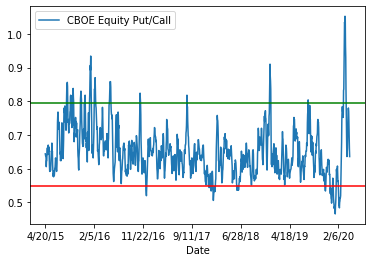

In [483]:
# Plotting the Bull/Bear Ratio 
plt.figure();
five_df.plot()
plt.axhline(five_fifth_percentile, color='R')
plt.axhline(five_ninety_fifth_percentile, color='G')

In [484]:
# Create a 25-day moving average
twenty_five_pc = five_year_final['CBOE Equity Put/Call'].rolling(25).mean()
twenty_five_pc.head()

Date
4/14/15   NaN
4/15/15   NaN
4/16/15   NaN
4/17/15   NaN
4/20/15   NaN
Name: CBOE Equity Put/Call, dtype: float64

In [485]:
# Construct a dataframe (25-day MA)
twenty_five_df = pd.DataFrame(data=twenty_five_pc)
twenty_five_df = twenty_five_df.dropna()
twenty_five_df

,CBOE Equity Put/Call
Date,
5/18/15,0.6356
5/19/15,0.6328
5/20/15,0.6324
5/21/15,0.6340
5/22/15,0.6300
...,...
4/7/20,0.8216
4/8/20,0.8220
4/9/20,0.8168


In [486]:
# Set the date as the index for the option dataframe
option_final = option_data_frame.set_index('Date')
option_final.head()

,CBOE Equity Put/Call
Date,
1/8/97,0.33
1/9/97,0.35
1/10/97,0.34
1/13/97,0.32
1/14/97,0.37


In [487]:
# What are the ercentiles (25-day MA)
print("5th percentile of Bull/Bear : ", 
       np.percentile(twenty_five_df, 5)) 
print("95th percentile of Bull/Bear : ", 
       np.percentile(twenty_five_df, 95))

5th percentile of Bull/Bear :  0.5701200000000001
95th percentile of Bull/Bear :  0.7548400000000004


In [488]:
# Setting The Percentile Bands (25-day MA)
twenty_five_fifth_percentile = np.percentile(twenty_five_df, 5)
twenty_five_ninety_fifth_percentile = np.percentile(twenty_five_df, 95)

<Figure size 432x288 with 0 Axes>

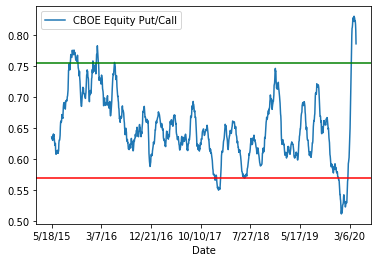

In [489]:
# Plotting the Bull/Bear Ratio (25-day MA) 
plt.figure();
twenty_five_df.plot()
plt.axhline(twenty_five_fifth_percentile, color='R')
plt.axhline(twenty_five_ninety_fifth_percentile, color='G')

In [490]:
# What are the Percentiles
print("5th percentile of Bull/Bear : ", 
       np.percentile(five_year_final, 5)) 
print("95th percentile of Bull/Bear : ", 
       np.percentile(five_year_final, 95))

5th percentile of Bull/Bear :  0.52
95th percentile of Bull/Bear :  0.85


In [491]:
# Setting The Percentile Bands 
fifth_percentile = np.percentile(five_year_final, 5)
ninety_fifth_percentile = np.percentile(five_year_final, 95)

<Figure size 432x288 with 0 Axes>

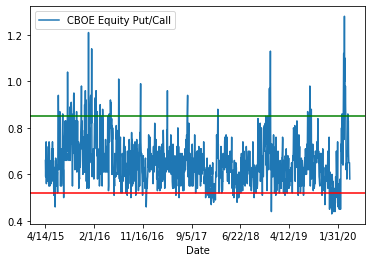

In [492]:
# Plotting the Bull/Bear Ratio 
plt.figure();
five_year_final.plot()
plt.axhline(fifth_percentile, color='R')
plt.axhline(ninety_fifth_percentile, color='G')

In [493]:
# Define the option signal
def option_signal(five_year_final):
    results = []
    for i in five_year_final:
        if i <= fifth_percentile:
            results.append(-1)
        elif i >= ninety_fifth_percentile:
            results.append(1)
        else: 
            results.append(0)
    
    return results

In [494]:
# Create a dataframe for the 5-year signal
signal = option_signal(five_year_final.values)
signal_df = pd.DataFrame(data=signal)
signal_df.head()

# Setting the signal 
option_signal_df = pd.concat([five_year_clean['Date'], signal_df], axis='columns', join='inner')
option_signal_df.index = five_year_clean['Date']
option_signal_df = option_signal_df.iloc[:, 1:]

# Rename the dataframe column
option_signal_df = option_signal_df.rename(columns = {0: 'Option_Signal'})
option_signal_df.tail()

,Option_Signal
Date,
4/7/20,0
4/8/20,0
4/9/20,0
4/13/20,0
4/14/20,0


In [495]:
# Signals for Option
def option_signal(five_df):
    results = []
    for i in five_df:
        if i <= five_fifth_percentile:
            results.append(-1)
        elif i >= five_ninety_fifth_percentile:
            results.append(1)
        else: 
            results.append(0)
    
    return results

In [496]:
# Create the 5-year signal dataframe
five_signal = option_signal(five_df.values)
five_signal_df = pd.DataFrame(data=signal)
five_signal_df.head()

,0
0,0
1,0
2,0
3,0
4,0


In [497]:
# Setting the Signal 
five_option_signal_df = pd.concat([five_year_clean['Date'], five_signal_df], axis='columns', join='inner')
five_option_signal_df.index = five_year_clean['Date']
five_option_signal_df = five_option_signal_df.iloc[:, 1:]
five_option_signal_df.head()

,0
Date,
4/14/15,0
4/15/15,0
4/16/15,0
4/17/15,0
4/20/15,0


In [498]:
# Setting the New Dataframe
five_day_pc = five_option_signal_df.rename(columns = {0: 'CBOE 5-Day Equity Put/Call'})
five_day_pc.tail()

,CBOE 5-Day Equity Put/Call
Date,
4/7/20,0
4/8/20,0
4/9/20,0
4/13/20,0
4/14/20,0


In [499]:
# Signals for Option
def option_signal(twenty_five_df):
    results = []
    for i in twenty_five_df:
        if i <= twenty_five_fifth_percentile:
            results.append(-1)
        elif i >= twenty_five_ninety_fifth_percentile:
            results.append(1)
        else: 
            results.append(0)
    
    return results

In [500]:
# Create the 25-day signal dataframe 
twenty_five_signal = option_signal(twenty_five_df.values)
twenty_five_signal_df = pd.DataFrame(data=twenty_five_signal)
twenty_five_signal_df.head()

,0
0,0
1,0
2,0
3,0
4,0


In [501]:
# Merge the dataframes
twenty_five_option_signal = pd.merge(five_year_merge,twenty_five_signal_df,left_index=True, right_index=True, how = 'left')
twenty_five_option_signal.fillna(method = 'ffill', inplace = True)
twenty_five_option_signal.dropna(inplace=True)
twenty_five_option_signal.head()

,Date,CBOE Equity Put/Call,0
0,4/14/15,0.66,0.0
1,4/15/15,0.59,0.0
2,4/16/15,0.67,0.0
3,4/17/15,0.74,0.0
4,4/20/15,0.56,0.0


In [502]:
# Setting the New Dataframe
twenty_five_day_pc = twenty_five_option_signal.rename(columns = {0: 'CBOE 25-Day Equity Put/Call'})
twenty_five_day_pc.tail()

,Date,CBOE Equity Put/Call,CBOE 25-Day Equity Put/Call
1246,4/7/20,0.65,1.0
1247,4/8/20,0.65,1.0
1248,4/9/20,0.65,1.0
1249,4/13/20,0.65,1.0
1250,4/14/20,0.58,1.0


## AAII Sentiment Signal

In [503]:
# Calling in the Quandl API Key 
api_key = os.getenv("QUANDL_API_KEY")
print(len(api_key))

20


In [504]:
# Quandl url
request_url = "https://www.quandl.com/api/v3/datasets/WIKI/AMD.json?api_key="

# Concatenate request_url and api_key. Store as new variable
request_url_rfd = request_url + api_key

# Execute get request
response_data = quandl.get("AAII/AAII_SENTIMENT")
response_data.head()

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
1987-06-26,NaN,NaN,NaN,NaN,NaN,NaN,0.386014,0.489178,0.28285,NaN,NaN,NaN
1987-07-17,NaN,NaN,NaN,NaN,NaN,NaN,0.386014,0.489178,0.28285,314.59,307.63,314.59
1987-07-24,0.36,0.50,0.14,1.0,NaN,0.22,0.386014,0.489178,0.28285,311.39,307.81,309.27
1987-07-31,0.26,0.48,0.26,1.0,NaN,0.00,0.386014,0.489178,0.28285,318.66,310.65,318.66
1987-08-07,0.56,0.15,0.29,1.0,NaN,0.27,0.386014,0.489178,0.28285,323.00,316.23,323.00


In [505]:
# Send to csv
response_data.to_csv("../1/Resources/Sentiment_Data.csv")

# Reading in and cleaning the CSV File 
sentiment_data = pd.read_csv("../1/Resources/Sentiment_Data.csv")
sentiment_data = sentiment_data.dropna()
sentiment_data.head()

,Date,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
9,1987-09-11,0.50,0.23,0.27,1.0,0.46625,0.23,0.384907,0.488293,0.281522,321.98,313.56,321.98
10,1987-09-18,0.60,0.29,0.11,1.0,0.49625,0.49,0.384907,0.488293,0.281522,323.08,314.86,314.86
11,1987-09-25,0.53,0.17,0.30,1.0,0.53000,0.23,0.384907,0.488293,0.281522,321.19,310.54,320.16
12,1987-10-02,0.44,0.26,0.30,1.0,0.51500,0.14,0.384907,0.488293,0.281522,328.07,321.69,328.07
13,1987-10-09,0.46,0.39,0.15,1.0,0.51625,0.31,0.384907,0.488293,0.281522,328.08,311.07,311.07


In [506]:
# 5-Year Dataframe
five_year_sentiment = sentiment_data.loc[1448:1708]
five_year_sentiment = five_year_sentiment.reset_index()

# Creating the 5-Year Bull/Bear Ratio in Jupyter 
bull_bear_indicator_5= (five_year_sentiment['Bullish']/(five_year_sentiment['Bullish']+five_year_sentiment['Neutral']+five_year_sentiment['Bearish']))

In [507]:
# What are the Percentiles
print("5th percentile of Bull/Bear : ", 
       np.percentile(bull_bear_indicator_5, 5)) 
print("95th percentile of Bull/Bear : ", 
       np.percentile(bull_bear_indicator_5, 95)) 

5th percentile of Bull/Bear :  0.221739
95th percentile of Bull/Bear :  0.451049


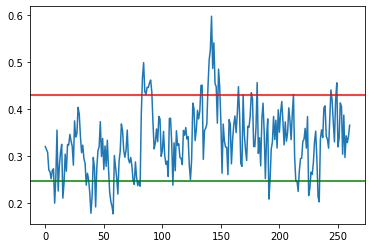

In [508]:
# Setting Percentile Bands 
tenth_percentile_5 = np.percentile(bull_bear_indicator_5, 10)
ninety_percentile_5 = np.percentile(bull_bear_indicator_5, 90)

# Plotting the Bull/Bear Ratio 
plt.figure();
bull_bear_indicator_5.plot()
plt.axhline(tenth_percentile_5, color='g')
plt.axhline(ninety_percentile_5, color='r')

In [509]:
# Signals for Sentiment 
def sentiment_signal(bull_bear_indicator_5):
    results = []
    for i in bull_bear_indicator_5:
        if i <= tenth_percentile_5:
            results.append(1)
        elif i >= ninety_percentile_5:
            results.append(-1)
        else: 
            results.append(0)
    
    return results

In [510]:
# Create a datafrane for the signal
aaii_sentiment_signal = sentiment_signal(bull_bear_indicator_5)
aaii_sentiment_signal_df = pd.DataFrame(aaii_sentiment_signal)
aaii_sentiment_signal_df.head()

# Setting the signal 
aaii_df = pd.concat([five_year_sentiment['Date'], signal_df], axis='columns', join='inner')
aaii_df.index = aaii_df['Date']
aaii_df = aaii_df.iloc[:, 1:]

In [511]:
# Setting the New Dataframe
aaii_signal_df = aaii_df.rename(columns = {0: 'AAII_Signal'})
aaii_signal_df.tail()
aaii_signal_df.head()

,AAII_Signal
Date,
2015-04-16,0
2015-04-23,0
2015-04-30,0
2015-05-07,0
2015-05-14,0


## News Signal

In [512]:
# Download/Update the VADER Lexicon
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Kebbin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [513]:
# Reading the News API key enviroment variable
api_key = os.getenv("news_api")

# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [514]:
# Create a df
path = Path("../1/Resources/US_stock_tickers.csv")
df = pd.read_csv(path)

# Assign a variable to the dictionary lookup
df_set = df.set_index("Symbol")
to_dict = df_set.to_dict("dict") 
keyword = to_dict["Name"][f"{user_input}"]
keyword

'Amazon.com, Inc.'

In [515]:
# Fetch news headlines about a company
headlines = newsapi.get_everything(
    q= f" {keyword}",
    language="en",
    page_size=100,
    sort_by="relevancy"
)

# Print total articles
print(f"Total # of articles: {headlines['totalResults']}")

# Show sample article
headlines["articles"][0]

Total # of articles: 1473


{'source': {'id': 'reuters', 'name': 'Reuters'},
 'author': 'Reuters Editorial',
 'title': "Whole Foods' New York employee tests positive for coronavirus",
 'description': 'A Whole Foods Market employee working at one of its grocery stores in New York City tested positive for the coronavirus and was placed in quarantine, a spokeswoman for the Amazon.com Inc-owned company said on Thursday.',
 'url': 'https://www.reuters.com/article/us-health-coronavirus-wholefoods-idUSKBN2170B9',
 'urlToImage': 'https://s4.reutersmedia.net/resources_v2/images/rcom-default.png',
 'publishedAt': '2020-03-20T03:07:14Z',
 'content': '(Reuters) - A Whole Foods Market employee working at one of its grocery stores in New York City tested positive for the coronavirus and was placed in quarantine, a spokeswoman for the Amazon.com Inc-owned company said on Thursday. \r\nThe affected store was clo… [+159 chars]'}

In [516]:
# Create a sentiment scores dataframe for the articles
article_sentiments = []

for article in headlines["articles"]:
    try:

        text = article["content"]
        source = article["source"]["name"]
        date = article["publishedAt"][:10]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        
        article_sentiments.append({
            "Source": source,
            "Text": text,
            "Date": date,
            "Compound Score": compound,

        })
        
    except AttributeError:
        pass
    
# Create DataFrame
sentiment_df = pd.DataFrame(article_sentiments)

# Reorder DataFrame columns
cols = ["Date", "Source","Text", "Compound Score"]
sentiment_df = sentiment_df[cols]
sentiment_df.tail()

,Date,Source,Text,Compound Score
81,2020-04-06,Yahoo.com,Apr.06 -- Amazon.com Inc. has played an import...,0.6142
82,2020-03-20,The Times of India,By Bijou George and Rahul SatijaAn Indian bric...,-0.5574
83,2020-03-30,Forbes.com,Figure 1: This week HP unveiled three new endp...,0.7845
84,2020-03-26,Forbes.com,"The logos for Facebook Inc., Amazon.com Inc., ...",0.0000
85,2020-03-26,Indianexpress.com,By: Reuters | San Francisco | \r\nPublished: M...,-0.5719


In [517]:
# Drop unnecessary columns
sentiment_df = sentiment_df.drop(columns=["Source","Text"])

# Take the daily average score 
sentiment_df = sentiment_df.groupby("Date").mean()

# Sort by date
sentiment_df = sentiment_df.sort_values(by="Date",ascending=False)

# Generate a trading signal based on polarity score
sentiment_df["News_Signal"] = np.where(sentiment_df["Compound Score"]>=.05,1,np.where(sentiment_df["Compound Score"]<=-.05,-1,0))

# Print news signal df
news_signal_df = sentiment_df.drop(columns=["Compound Score"])
news_signal_df.head()


,News_Signal
Date,
2020-04-16,0
2020-04-15,1
2020-04-14,1
2020-04-13,-1
2020-04-12,-1


In [518]:
# Merge signal dataframes
merge_1_df = pd.merge(technical_signals_df, option_signal_df, left_index=True, right_index=True, how="left")
merge_2_df = pd.merge(merge_1_df, aaii_signal_df, left_index=True, right_index=True, how="left")
merge_3_df = pd.merge(merge_2_df, news_signal_df, left_index=True, right_index=True, how="left")

In [520]:
merge_3_df.fillna(method = "ffill", inplace = True)

In [521]:
merge_4_df = merge_3_df.fillna(0)

In [522]:
signals_df = merge_4_df
signals_df.head()

,Open,High,Low,Close,Volume,SP_Signal,V_Signal,Option_Signal,AAII_Signal,News_Signal
Date,,,,,,,,,,
2020-04-13,2040.00,2180.00,2038.00,2168.87,6716709,-1.0,0,0.0,0.0,-1.0
2020-04-09,2044.30,2053.00,2017.66,2042.76,4612716,0.0,0,0.0,0.0,1.0
2020-04-08,2021.00,2044.00,2011.15,2043.00,3943414,0.0,0,0.0,0.0,1.0
2020-04-07,2017.11,2035.72,1997.62,2011.60,5082216,0.0,0,0.0,0.0,-1.0
2020-04-06,1936.00,1998.52,1930.02,1997.59,5723143,0.0,0,0.0,0.0,1.0


In [523]:
signals_df.to_csv("signals.csv")